In [4]:
import numpy as np
import healpy as hp
from matplotlib.pyplot import *
# from cmblensplus/wrap/
import curvedsky as cs
# from cmblensplus/utils/
import cmb as CMB
import plottools as pl
import constant as c
import analysis as ana
import binning as bn
# others
import local
import tools_multitracer as mass
import tools_delens
import tools_cmb
import warnings
warnings.filterwarnings("ignore")

In [5]:
pobj = local.analysis()
cobj = tools_cmb.cmb_map()
dobj = tools_delens.filename()

In [16]:
simn = 99
lbmin, lbmax = 2, 190
L = np.linspace(0,lbmax,lbmax+1)
bN = 20
area = 'lbonly'
#area = 'lbs4'
mb = bn.multipole_binning(bN,lmin=lbmin,lmax=lbmax,lstart=lbmin,spc='')

In [17]:
if area=='lbs4': fsky = .2133
if area=='lbonly': fsky = .2531
Ol = np.zeros((simn,lbmax+1-lbmin))
Rl = np.zeros((simn,lbmax+1-lbmin))
Ll = np.zeros((simn,lbmax+1-lbmin))
Xl = np.zeros((simn,lbmax+1-lbmin))
Ob = np.zeros((simn,bN))
Rb = np.zeros((simn,bN))
Lb = np.zeros((simn,bN))
Xb = np.zeros((simn,bN))
for rlz in range(1,simn+1):
    obb, rbb, lbb, xbb = np.loadtxt(dobj.cl[area][3][rlz],usecols=(0,1,2,3),unpack=True)[:,lbmin:lbmax+1]
    Ol[rlz-1,:] = obb/fsky
    Rl[rlz-1,:] = rbb/fsky
    Ll[rlz-1,:] = lbb/fsky
    Xl[rlz-1,:] = xbb/fsky
    Ob[rlz-1,:] = bn.binning(obb,mb)/fsky
    Rb[rlz-1,:] = bn.binning(rbb,mb)/fsky
    Lb[rlz-1,:] = bn.binning(lbb,mb)/fsky
    Xb[rlz-1,:] = bn.binning(xbb,mb)/fsky

In [18]:
mOl = np.mean(Ol,axis=0)
mRl = np.mean(Rl,axis=0)
mLl = np.mean(Ll,axis=0)
mXl = np.mean(Xl,axis=0)
mOb = np.mean(Ob,axis=0)
mRb = np.mean(Rb,axis=0)
mLb = np.mean(Lb,axis=0)
mXb = np.mean(Xb,axis=0)
mAl = mXl/mLl
mAb = mXb/mLb

In [19]:
Dl = Ol - 2*mAl*Xl + mAl**2*Ll
Db = Ob - 2*mAb*Xb + mAb**2*Lb
mDl = np.mean(Dl,axis=0)
mDb = np.mean(Db,axis=0)

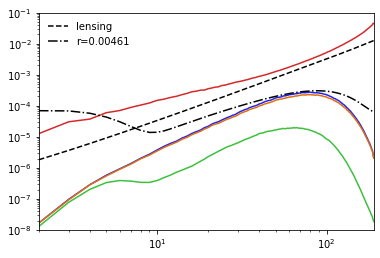

In [20]:
xlim(2,lbmax)
ylim(1e-8,1e-1)
Lfac = c.Tcmb**2*L[lbmin:]*(L[lbmin:]+1)/(2*np.pi)
loglog(L[lbmin:],Lfac*mOl)
loglog(L[lbmin:],Lfac*mDl)
loglog(L[lbmin:],Lfac*mRl*0.00461)
loglog(L[lbmin:],Lfac*pobj.clfg[lbmin:lbmax+1])
loglog(L[lbmin:],Lfac*pobj.lcl[2][lbmin:lbmax+1],label='lensing',color='k',ls='--')
loglog(L[lbmin:],Lfac*pobj.tcl[2][lbmin:lbmax+1]*0.00461,label='r=0.00461',color='k',ls='-.')
legend()

In [21]:
rs = np.arange(-7e-3,7e-3,5e-5)
obb0, lbb0, xbb0 = np.loadtxt(dobj.cl[area][3][simn+1],usecols=(0,2,3),unpack=True)[:,lbmin:lbmax+1]
oOl = obb0/fsky
oDl = oOl - 2*mAl*xbb0/fsky + mAl**2*lbb0/fsky
oOb = bn.binning(oOl,mb)
oDb = oOb - 2*mAb*bn.binning(xbb0/fsky,mb) + mAb**2*bn.binning(lbb0/fsky,mb)

In [22]:
icov = np.linalg.inv(np.cov(Ob,rowvar=0))
lnLo = np.zeros(len(rs))
for ri, r in enumerate(rs):
    sOb = mOb + r*mRb
    lnLo[ri] = ana.lnLHL(oOb/sOb,mOb,icov)

In [23]:
icov = np.linalg.inv(np.cov(Db,rowvar=0))
lnLd = np.zeros(len(rs))
for ri, r in enumerate(rs):
    sDb = mDb + r*mRb
    lnLd[ri] = ana.lnLHL(oDb/sDb,mDb,icov)

In [24]:
from scipy.optimize import curve_fit
# Let's create a function to model and create data
def pdf_gauss(xs, amp, mean, sigma):
    return amp*np.exp(-(xs-mean)**2/(2*sigma**2))

1.8449783415906083
1.5745986564722438


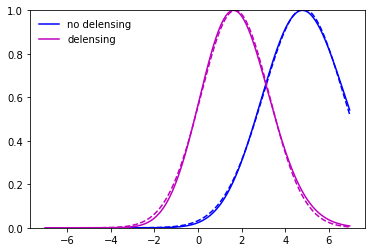

In [25]:
#xlim(-7,7)
ylim(0,1)
x = 1e3*rs
Po = np.exp(lnLo-np.max(lnLo))
Pd = np.exp(lnLd-np.max(lnLd))
popto, __ = curve_fit(pdf_gauss, x, Po)
print(popto[2])
poptd, __ = curve_fit(pdf_gauss, x, Pd)
print(poptd[2])
plot(x,Po,label='no delensing',color='b')
plot(x,pdf_gauss(x, popto[0], popto[1], popto[2]),color='b',ls='--')
plot(x,Pd,label='delensing',color='m')
plot(x,pdf_gauss(x, poptd[0], poptd[1], poptd[2]),color='m',ls='--')
legend()